# Shelter Animal Outcomes
https://www.kaggle.com/c/shelter-animal-outcomes

In [125]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import re

Here I'm just importing the gzipped training data (CSV) using the `"AnimalID"` as the index column, parsing the thrid column as a date, and then showing the first few data entries.

In [196]:
# downloading directly from the Kaggle site doesn't work
#import requests
#from lxml import html
#import urllib

#data_url = 'https://www.kaggle.com/c/shelter-animal-outcomes/data'
#raw_page = requests.get(data_url)
#tree = html.fromstring(raw_page.content)

## Select all url links (XPath syntax http://www.w3schools.com/xml/xpath_intro.asp)
#links = tree.xpath('//td/a/@href')
#links = [s for s in links if 'csv' in s]
#train_link = [s for s in links if 'train' in s][0]
#train_data_url = 'https://www.kaggle.com' + train_link

#local_file, headers = urllib.urlretrieve(train_data_url, "train.csv.gz")

#train_data = requests.get(train_data_url)
#train_data.text

train_df = pd.read_csv("train.csv.gz", 
                       index_col="AnimalID", 
                       parse_dates=[2], 
                       na_values='Unknown')
train_df.head(5)

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


First, I'll look at all the possible classifications:

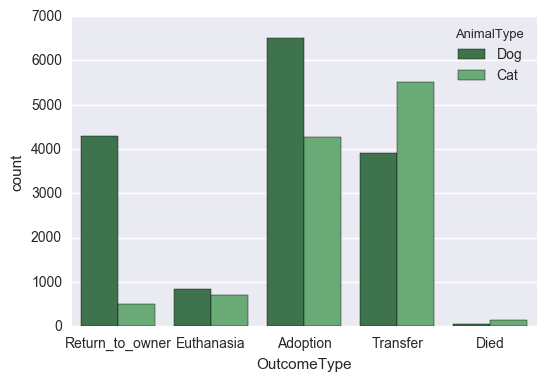

In [197]:
%matplotlib inline
g = sns.countplot(x="OutcomeType", hue="AnimalType", data=train_df, palette="Greens_d")

We clearly see that there are five outcome classes in which the type of animal (dog or cat) plays a significant role. Next we can look at the `''OutcomeSubtype''` to try to get an understanding of it's relationship to `''OutcomeType''` (this is extraneous since this column doesn't exist in the test data).

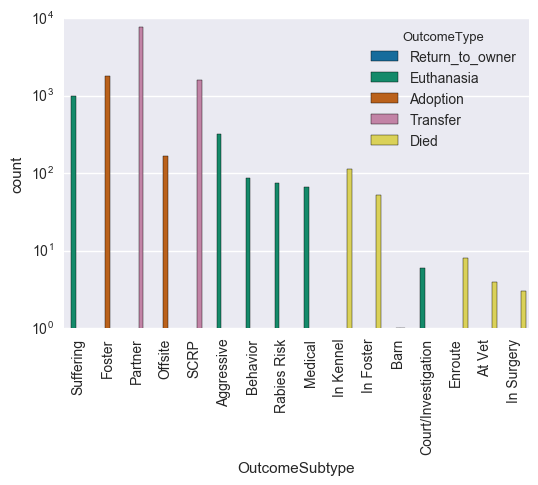

In [198]:
%matplotlib inline
g = sns.countplot(x="OutcomeSubtype", hue="OutcomeType", data=train_df, palette="colorblind")
nothing = g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.get_axes().set_yscale('log')

Of course, it's easy to see why `"OutcomeSubtype"` isn't provided in the test set ;)

Next, I'll plot a few variables to get a feel for what the data looks like.

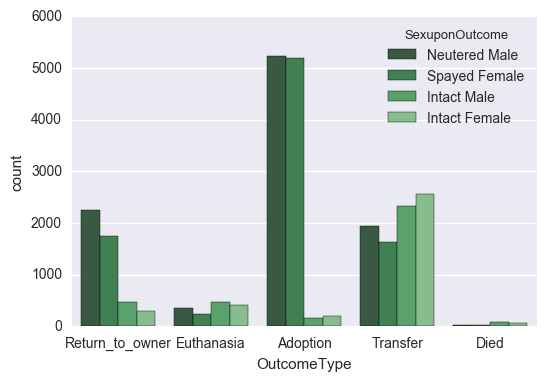

In [201]:
%matplotlib inline
g = sns.countplot(x="OutcomeType", hue="SexuponOutcome", data=train_df, palette="Greens_d")

Clearly, being neutered or spayed has a large impact on the outcome.

## Data preprocessing

It's immediately clear that some of these columns have information that could be more effectively split into other columns for machine learning purposes. For instance, the `SexuponOutcome` column has information about the sex and whether or not the animal is spayed or neutered. The `DateTime`, `SexuponOutcome`, `Breed`, and `Color` can all be further split.

* `SexuponOutcome` can be split into `IsFixed` and `Sex` (should account for `nan` values)
* `Breed` can be split into `PureBred`, `Size`, and `HairLength` (use only `PureBred` for now)
* `Color` can be split into `MixedColor`, `Patterned`, and `DarkColor`

First, I'll drop the `"OutcomeSubtype"` column since this can't give us useful information.

In [187]:
train_df.drop('OutcomeSubtype', axis=1, inplace=True)

Here I'll split date and time data into a more usable form. Specifically, I think that the month and day of the week may play a role.

In [188]:
# split date and time data
# replace 'DateTime' column with 'OutcomeHour', 'OutcomeWeekday', 'OutcomeMonth', 'OutcomeYear' columns
dates_column_name = 'DateTime'
new_column_names = ['OutcomeHour', 'OutcomeWeekday', 'OutcomeMonth', 'OutcomeYear']

sub_df = train_df[dates_column_name].apply(lambda x: pd.Series([x.time().hour, x.weekday(), x.month, x.year]))

sub_df.columns = new_column_names

train_df = pd.concat([train_df, sub_df], axis=1)
train_df.drop(dates_column_name, axis=1, inplace=True)

Now I'll split the `"SexuponOutcome"` column into as many columns as unique entries (four, in this case excluding NaNs).

In [189]:
sex_column_name = 'SexuponOutcome'

# one-hot encode the sex information
dum = pd.get_dummies(train_df.SexuponOutcome)
new_columns_names = []
for n in dum.columns:
    new_columns_names.append(n.replace(' ', ''))
dum.columns = new_columns_names

train_df = pd.concat([train_df, dum], axis=1)
train_df.drop(sex_column_name, axis=1, inplace=True)

It's much better to convert the age from a string to quantitative value. Here, I choose to convert it to days. I'll also do the same for animal type (dog/cat).

In [190]:
# convert AgeuponOutcome to days rather than a string
value_map = {'week': 7, 'year': 365, 'month': 30, 'day': 1}
def age_transformer (x):
    if type(x) is not str:
        return x
    m = re.match(r"(\w+) (\w+)", x)
    quantity = int(m.group(1))
    unit = m.group(2) if m.group(2)[-1] is not 's' else m.group(2)[:-1] # mind the 's' in the units description
    return quantity*value_map[unit]
train_df.AgeuponOutcome = train_df.AgeuponOutcome.apply(age_transformer)

In [191]:
# one-hot encode AnimalType
atype_column_name = 'AnimalType'

# one-hot encode the animal type information
dum = pd.get_dummies(train_df.AnimalType)
new_columns_names = []
for n in dum.columns:
    new_columns_names.append(n.replace(' ', ''))
dum.columns = new_columns_names

train_df = pd.concat([train_df, dum], axis=1)
train_df.drop(atype_column_name, axis=1, inplace=True)

Now to convert the `"Breed"` column to a more managable format. For now, I'll just make the `"PureBred"` column.

In [192]:
# split breed information
breed_column_name = 'Breed'
new_column_names = ['PureBred']

# need to process each Breed name one by one
value_map = {}
for n in train_df.Breed.unique():
    pure = 1
    if 'Mix' in n or '/' in n:
        pure = 0
    value_map[n] = pd.Series([pure])

sub_df = train_df[breed_column_name].apply(lambda x: value_map[x])

sub_df.columns = new_column_names

train_df = pd.concat([train_df, sub_df], axis=1)
train_df.drop(breed_column_name, axis=1, inplace=True)

Finally, I'll process the `"Color"` information

In [193]:
# split color information
color_column_name = 'Color'
new_column_names = ['MixedColor', 'Patterned']#, 'DarkColor']

# need to process each Color name one by one
patterned_names = ['Tabby', 'Tiger', 'Brindle', 'Calico', 
                   'Fawn', 'Point', 'Tortie', 'Torbie', 'Tick', 
                   'Merle', 'Buff']
value_map = {}
for n in train_df.Color.unique():
    mixed = 0
    patterned = 0
    dark = 0
    for pn in patterned_names:
        if pn in n:
            patterned = 1
            break
    if '/' in n or patterned == 1:
        mixed = 1
    for dn in dark_names:
        if dn in n:
            dark = 1
            break
    value_map[n] = pd.Series([mixed, patterned])#, dark])

sub_df = train_df[color_column_name].apply(lambda x: value_map[x])

sub_df.columns = new_column_names

train_df = pd.concat([train_df, sub_df], axis=1)
train_df.drop(color_column_name, axis=1, inplace=True)

Let's now look at the columns we can play with:

In [195]:
train_df.columns

Index([u'Name', u'OutcomeType', u'AgeuponOutcome', u'OutcomeHour',
       u'OutcomeWeekday', u'OutcomeMonth', u'OutcomeYear', u'IntactFemale',
       u'IntactMale', u'NeuteredMale', u'SpayedFemale', u'Cat', u'Dog',
       u'PureBred', u'MixedColor', u'Patterned'],
      dtype='object')

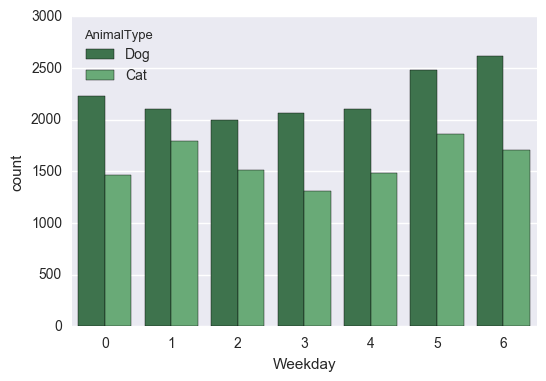

In [85]:
%matplotlib inline
g = sns.countplot(x="Weekday", hue="AnimalType", data=train_df, palette="Greens_d")
#g = sns.FacetGrid(train_df, col="AnimalType")
#g.map(sns.distplot, "OutcomeType")

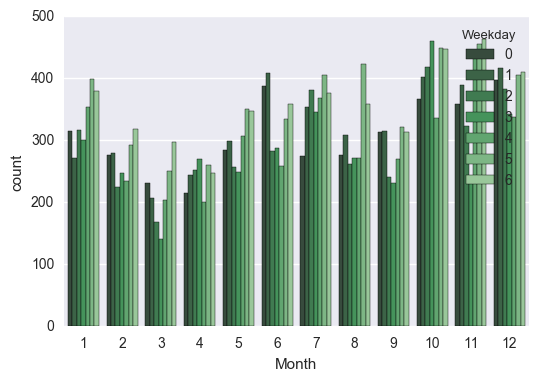

In [86]:
%matplotlib inline
g = sns.countplot(x="Month", hue="Weekday", data=train_df, palette="Greens_d")